In [1]:
library(DBI)
library(stringr)
library(wordVectors)

In [2]:
sql_con <- dbConnect(RSQLite::SQLite(), "/home/cbrom/workspace/2015-02.db")

In [5]:
get_time <- function(){
    return(as.numeric(Sys.time()))
}

In [8]:
start <- get_time()
sql_data <- dbGetQuery(sql_con, "SELECT parent, comment from parent_reply")
paste('Total time to read:', get_time() - start, sep=" ")

[1] "Total time to read: 31.6328413486481"

In [9]:
paste('Total rows:', length(sql_data$parent), sep=" ")

[1] "Total rows: 4506428"

In [10]:
head(sql_data)

parent,comment
&gt; CDBOOT: Cannot boot from CD - Code: 5 newlinechar newlinechar Have a read here: http://www.unawave.de/windows-7-tipps/code5-error.html?lang=EN,Ok will do!
Sounds like someone wants some pants jerky,I'm an avid fan of pants meat.
"That's definitely a valid point, but I would argue that the examples I gave are any combination appealing to the average r/MLSer and infrequent enough so as to not be a nuisance that it might be worth discussing including them as on-topic","But where do we draw the line on frequency? And based on the fact that we've doubled 2x, we're going to be getting a LOT of posts and most people are indeed here for MLS, the rest is fairly extraneous."
I feel like Jotaro would like Beat-em-ups more than RATED MATURE games.,In part 6 he starts getting into Octodad
I think we've just discovered the fandom's sburb land.,Land of Pictures and Text
"Does anyone know of a stream site that I can get a good quality stream at. I usually use GCL, but where it's on NHLN I don't think they broadcast online newlinechar",Hey tim! newlinechar newlinechar http://slipstreamtv.co/ is usually pretty good


In [11]:
caps = "([A-Z])"
prefixes = "(Mr|St|Mrs|Ms|Dr|Prof|Capt|Cpt|Lt|Mt)\\."
suffixes = "(Inc|Ltd|Jr|Sr|Co)"
acronyms = "([A-Z][.][A-Z][.](?:[A-Z][.])?)"
starters = "(Mr|Mrs|Ms|Dr|He\\s|She\\s|It\\s|They\\s|Their\\s|Our\\s|We\\s|But\\s|However\\s|That\\s|This\\s|Wherever)"
websites = "\\.(com|edu|gov|io|me|net|org)"
digits = "([0-9])"

split_into_sentences <- function(text){
  text = gsub("\n|\r\n"," ", text)
  text = gsub(prefixes, "\\1<prd>", text)
  text = gsub(websites, "<prd>\\1", text)
  text = gsub('www\\.', "www<prd>", text)
  text = gsub("Ph.D.","Ph<prd>D<prd>", text)
  text = gsub(paste0("\\s", caps, "\\. "), " \\1<prd> ", text)
  text = gsub(paste0(acronyms, " ", starters), "\\1<stop> \\2", text)
  text = gsub(paste0(caps, "\\.", caps, "\\.", caps, "\\."), "\\1<prd>\\2<prd>\\3<prd>", text)
  text = gsub(paste0(caps, "\\.", caps, "\\."), "\\1<prd>\\2<prd>", text)
  text = gsub(paste0(" ", suffixes, "\\. ", starters), " \\1<stop> \\2", text)
  text = gsub(paste0(" ", suffixes, "\\."), " \\1<prd>", text)
  text = gsub(paste0(" ", caps, "\\."), " \\1<prd>",text)
  text = gsub(paste0(digits, "\\.", digits), "\\1<prd>\\2", text)
  text = gsub("...", "<prd><prd><prd>", text, fixed = TRUE)
  text = gsub('\\.”', '”.', text)
  text = gsub('\\."', '\".', text)
  text = gsub('\\!"', '"!', text)
  text = gsub('\\?"', '"?', text)
  text = gsub('\\.', '.<stop>', text)
  text = gsub('\\?', '?<stop>', text)
  text = gsub('\\!', '!<stop>', text)
  text = gsub('<prd>', '.', text)
  sentence = strsplit(text, "<stop>\\s*")
  return(sentence)
}

In [78]:
clean_text <- function(pairs, out_name){
    total_rows <- nrow(pairs)
    start <- get_time()
    out_file <- file(out_name, 'a')
    for (row in 1: 50) {
#         for (row in 1: nrow(pairs)){
        parent <- pairs$parent[row]
        comment <- pairs$comment[row]

        # remove newLines
        par_no_tabs <- gsub("\\t", " ", parent)
        com_no_tabs <- gsub("\\t", " ", comment)

        # normalize to alpha and dot(.)
        par_alpha <- gsub("[^a-zA-Z\\.]", " ", par_no_tabs)
        com_alpha <- gsub("[^a-zA-Z\\.]", " ", com_no_tabs)

        # strip
        par_strip <- gsub("^\\s+|\\s+$", "", par_alpha)
        com_strip <- gsub("^\\s+|\\s+$", "", com_alpha)
        
        # change multi space to 1
        par_multi_space <- gsub(" +", " ", par_strip)
        com_multi_space <- gsub(" +", " ", com_strip)

        # lowercase
        par_clean <- tolower(par_multi_space)
        com_clean <- tolower(com_multi_space)

        # tokenize
        par_sents <- split_into_sentences(par_clean)
        for (i in {x <- 1:length(par_sents[[1]])}){
            par_sents[[1]][i] <- sub("[\\.]", "", par_sents[[1]][i])
        }

        com_sents <- split_into_sentences(com_clean)
        for (i in {x <- 1:length(com_sents[[1]])}){
            com_sents[[1]][i] <- sub("[\\.]", "", com_sents[[1]][i])
        }
        
        print(par_sents)

        if (length(par_clean) > 0 & str_count(par_clean, " ")> 0){
            for (idx in 1:length(par_sents[[1]])) {
                writeLines(par_sents[[1]][idx], out_file)
            }
        }
        if (length(com_clean) > 0 & str_count(com_clean, " ")> 0){
            for (idx in 1:length(com_clean[[1]])) {
                
                writeLines(com_sents[[1]][idx], out_file)
            }
        }

        if (row %% 500 == 0){
            total_time = get_time() - start
            paste('Completed ', round(row/total_rows), '% - ', row,
                 'rows in time', round(total_time / 60), 'min %',
                 round(total_time%%60), 'secs\r')
        }

        flush(out_file)
    }
    close(out_file)
    
}

In [79]:
start <- get_time()
clean_text(sql_data,  "/home/cbrom/workspace/test.txt")
paste('Total time to read:', get_time() - start, sep=" ")

[[1]]
[1] "gt cdboot cannot boot from cd code newlinechar newlinechar have a read here http wwwunawave."
[2] "de windows tipps code error"                                                                 
[3] "html lang en"                                                                                

[[1]]
[1] "sounds like someone wants some pants jerky"

[[1]]
[1] "that s definitely a valid point but i would argue that the examples i gave are any combination appealing to the average r mlser and infrequent enough so as to not be a nuisance that it might be worth discussing including them as on topic"

[[1]]
[1] "i feel like jotaro would like beat em ups more than rated mature games"

[[1]]
[1] "i think we ve just discovered the fandom s sburb land"

[[1]]
[1] "does anyone know of a stream site that i can get a good quality stream at"               
[2] "i usually use gcl but where it s on nhln i don t think they broadcast online newlinechar"

[[1]]
[1] "calling arabic women with burk

[1] "Total time to read: 0.754043340682983"

In [81]:
start <- get_time()
num_features <- 100
min_word_count <- 40
context <- 5
downsampling <- 1e-3
print("Training model ...")
model <- # train model here
model_name <- "model_full_r"
#save moodel here
# model.init_sims if possible 

[1] "Training model ..."


In [2]:
if (file.exists('r_model.bin')){
    model = read.vectors('r_model.bin')
} else {
    model <- train_word2vec(train_file = "/home/cbrom/workspace/full.txt",output_file = "./r_model.bin", vectors = num_features, window = context, threads = 4, min_count = min_word_count, negative_samples = 0)
}

Filename ends with .bin, so reading in binary format
Reading a word2vec binary file of 74968 rows and 100 columns


  |======================================================================| 100%


In [3]:
model %>% closest_to("feminist")

word,"similarity to ""feminist"""
feminist,1.0000000
leftist,0.8603994
radfem,0.8279134
feminism,0.8104408
mra,0.7954152
sjw,0.7806296
radical,0.7683609
traditionalist,0.7443550
libertarian,0.7441252
terf,0.7400675


In [4]:
model %>% closest_to(model[[c("fish","salmon","trout","shad","flounder","carp","roe","eels")]],50)

word,"similarity to model[[c(""fish"", ""salmon"", ""trout"", ""shad"", ""flounder"", ""carp"", ""roe"", ""eels"")]]"
trout,0.8102176
salmon,0.8087933
fish,0.7760958
eels,0.7630925
catfish,0.7350493
carp,0.7334241
scallops,0.7275365
caribou,0.7217015
shrimp,0.7189617
lamb,0.7179420


In [5]:
set.seed(10)
centers = 150
clustering = kmeans(model,centers=centers,iter.max = 40)

In [12]:
sapply(sample(1:centers,10),function(n) {
  names(clustering$cluster[clustering$cluster==n][1:10])
})

here,music,air,iimgurcom,u,day,gun,nbsp,card,most
post,song,engine,jpg,changetip,last,heavy,utf,memory,same
read,voice,battery,imgurcom,crest,next,weapons,ved,core,first
comment,album,fuel,gif,ayy,home,ship,qid,gb,best
reddit,rock,surface,wp,wot,week,tank,tbm,supply,world
please,band,wheel,uploads,dun,during,guns,isch,cpu,rest
check,songs,electric,png,doge,night,combat,bih,monitor,entire
link,dance,wire,img,opieop,later,auto,biw,internal,main
sub,tracks,rear,wikianocookienet,dogetipbot,th,unit,gameid,storage,middle
thread,kanye,repair,cdncom,bukkake,early,units,eventid,ram,worst


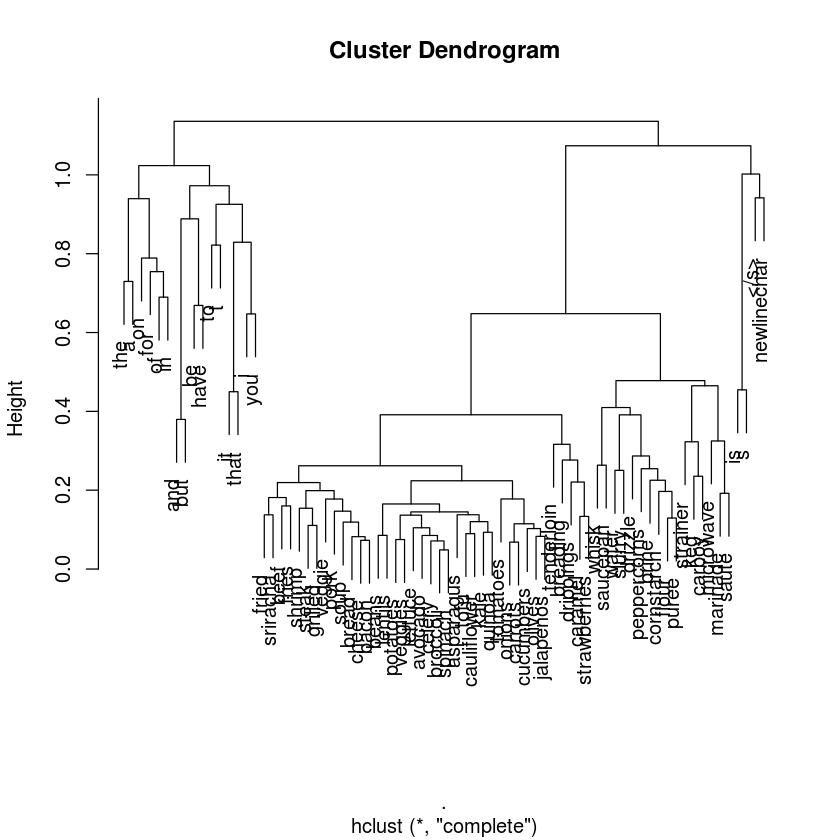

In [13]:
ingredients = c("madeira","beef","saucepan","carrots")
term_set = lapply(ingredients, 
       function(ingredient) {
          nearest_words = model %>% closest_to(model[[ingredient]],20)
          nearest_words$word
        }) %>% unlist
subset = model[[term_set,average=F]]
subset %>%
  cosineDist(subset) %>% 
  as.dist %>%
  hclust %>%
  plot